We are trying to prediction of full load electrical power output of a base load operated
combined cycle power plant (CHP) using machine learning methods like linearreg, decision tree, random forest and neural networks.
The data set is fully labled, has 5 features and almost 48000 instances of recorded data.

In [4]:
import os
import pandas as pd

def load_chp_data():
    xlsx_path = os.getcwd()+ "\chp.xlsx"
    return pd.read_excel(xlsx_path)

chp = load_chp_data()
chp.head()

,Ambient_T,Exhaust_Volume,Atmospheric_P,Relative Humidity,Electric_Power
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Next we should visualize the data to have a look.

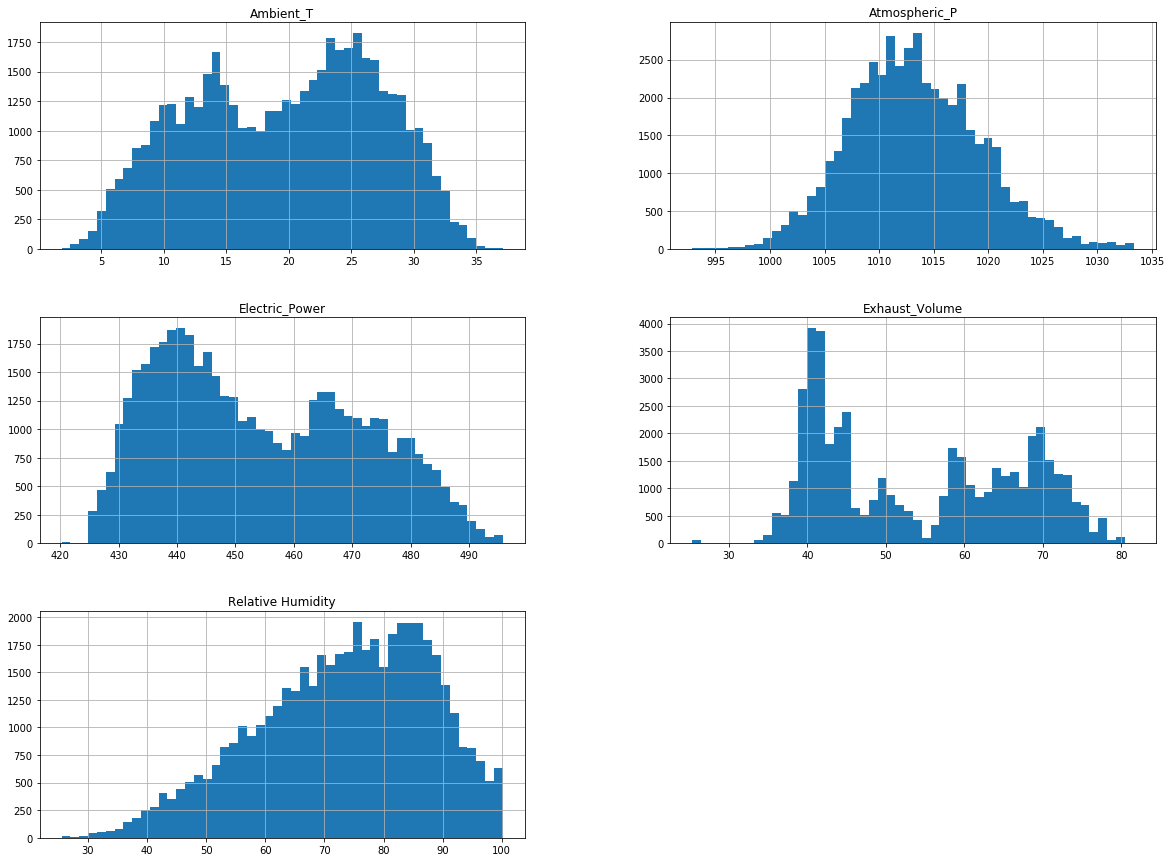

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt

chp.hist(bins=50, figsize=(20,15))
plt.show()

The original data set is broken 80% to 20% for aquiring a test set. data points are selected randomly.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(chp, chp["Atmospheric_P"]):
    strat_train_set = chp.loc[train_index]   #TRAIN_SET
    strat_test_set = chp.loc[test_index]     #TEST_SET


Now we try to understand (by visualisation) the temp/pressure range of plant operation data


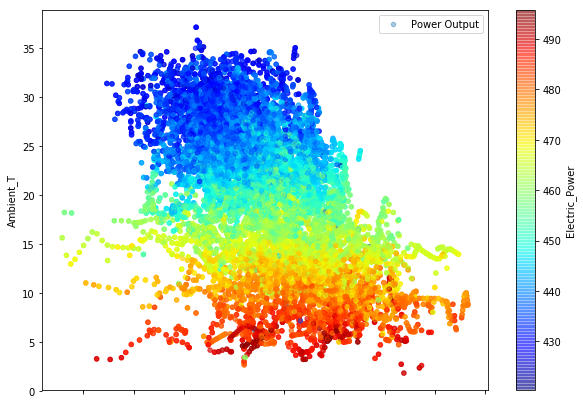

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt

chp = strat_train_set.copy()
chp.plot(kind="scatter", x="Atmospheric_P", y="Ambient_T", alpha=0.4,label="Power Output", figsize=(10,7),
c="Electric_Power", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()
plt.show()

Here we dig for some linear correlations in data

In [8]:
correlations = chp.corr()
correlations["Electric_Power"].sort_values(ascending=False)

Electric_Power       1.000000
Atmospheric_P        0.517521
Relative Humidity    0.389102
Exhaust_Volume      -0.870120
Ambient_T           -0.948504
Name: Electric_Power, dtype: float64

Pairwase scatter plot of parameters shown below.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238B293C7F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238B1F91C50>]], dtype=object)

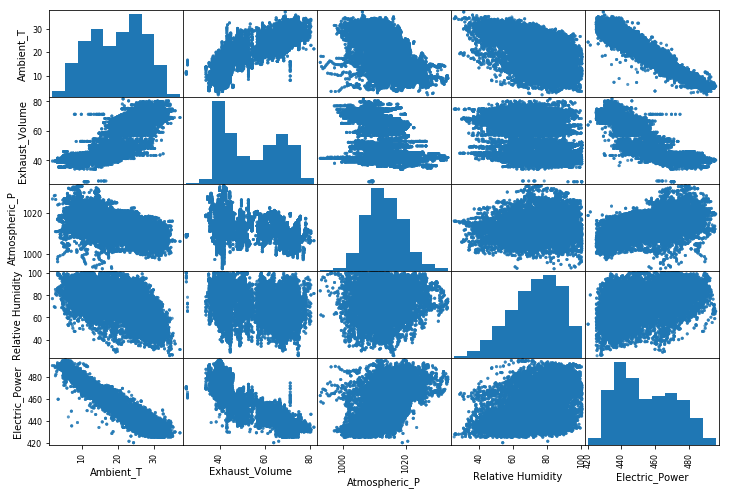

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

scatter_matrix(chp, figsize=(12, 8))

A closer look at Atmospheric Pressure & Ambient Temperature correlation with power output

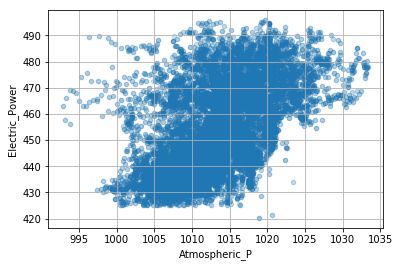

In [10]:
chp.plot(kind="scatter", x="Atmospheric_P", y="Electric_Power",
alpha=0.1, grid=1)

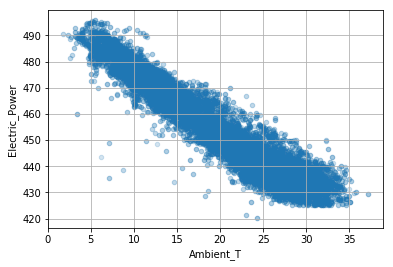

In [11]:
chp.plot(kind="scatter", x="Ambient_T", y="Electric_Power",
alpha=0.1, grid=1)

Data undergoes some transformation using Scikit-Learn’s pipeline class

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

chping = strat_train_set.drop("Electric_Power", axis=1)
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])
chping_num_tr = num_pipeline.fit_transform(chping)

In [13]:
from sklearn.compose import ColumnTransformer

chping = strat_train_set.drop("Electric_Power", axis=1)
chping_labels = strat_train_set["Electric_Power"].copy()
###########
num_attribs = list(chping)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)
    ])
chping_prepared = full_pipeline.fit_transform(chping)


Initiating LinearRegression

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(chping_prepared, chping_labels)
##############
from sklearn.compose import ColumnTransformer

num_attribs = list(chping)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
    ])

1st test of implementing the linear reggresion.

In [15]:
some_data = chping.iloc[:4]
some_labels = chping_labels.iloc[:4]
some_data_prepared = full_pipeline.fit_transform(some_data)
##########
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 474.93642364  472.30179557  432.51433158  437.64164862]
Labels: [464.56999999999999, 459.72000000000003, 448.00999999999999, 442.23000000000002]


Trying root mean square on results.

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

chping_predictions = lin_reg.predict(chping_prepared)
mrsq = mean_squared_error(chping_labels, chping_predictions)
l_rmse = np.sqrt(mrsq)
l_rmse

4.5310925240368674

Linear reg results are better than tipycally expected. Next we try for some nonlinearity in the data using Decision Trees.

In [17]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(chping_prepared, chping_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [18]:
chping_predictions = tree_reg.predict(chping_prepared)
tree_mse = mean_squared_error(chping_labels, chping_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

2.4839273025850123e-14

Looks too good to be true! Probabely an overfit. We should cross validate...
Implementing Scikit-Learn’s K-fold cross-validation feature.

In [19]:
#first a little code abstraction..
def display_scores(id):
    print("Scores:", id)
    print("Mean:", id.mean())
    print("Standard deviation:", id.std())

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, chping_prepared, chping_labels,
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [ 0.71820223  0.11546711  0.20644097  0.14906625  0.2347094   0.31128895
  0.16790607  0.25739728  0.21279358  0.14093643]
Mean: 0.25142082734
Standard deviation: 0.165360424944


And now let’s try RandomForestRegressor which works by training many Decision Trees on random subsets of
the features, then averaging out their predictions.

In [20]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
m = forest_reg.fit(chping_prepared, chping_labels)
scores = cross_val_score(forest_reg, chping_prepared, chping_labels,
                         cv=3, scoring="neg_mean_squared_error")
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 1.05474999  1.04746093  0.99169036]
Mean: 1.03130042405
Standard deviation: 0.0281661787002


Taking a second look at the data set, this could be predicted as the electric power shows very little sensitivity to the variables. At this stage our recommandation is introducing different variables to the model.

In [21]:
#doing some plotting here
print("Predictions:", forest_reg.predict((some_data_prepared)))
print("Labels:", list(some_labels))

Predictions: [ 475.634  471.556  433.881  439.629]
Labels: [464.56999999999999, 459.72000000000003, 448.00999999999999, 442.23000000000002]


Plotting the predictions to see whats what...

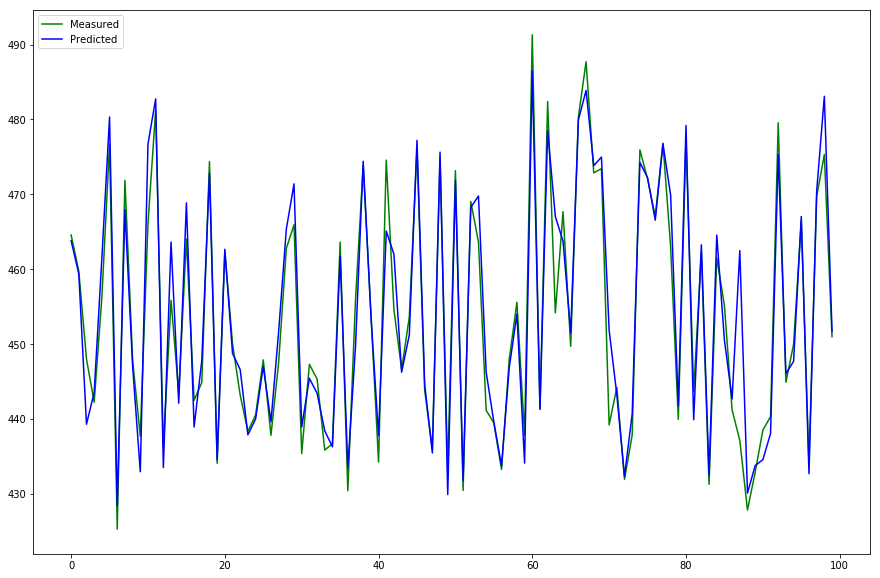

In [22]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np

x = np.arange(0,100) 
a=list(chping_labels.iloc[:100])
b=list(forest_reg.predict(full_pipeline.fit_transform(chping.iloc[:100])))
plt.figure(figsize=(15,10))
plt.plot(x, a,"g-", label="Measured")
plt.plot(x, b,"b-", label="Predicted")
plt.legend(loc='upper left')
#plt.plot(x, a,"g-", label="Measured", x, b,"b-", label="Predicted")

At this point we are mildly satisfied with Random Forest results. The next step would be trying multi layer perceptron and/or neural networks analysis.